# Stage 2 - Lesson 1: MLflow Setup

## What is MLflow?

MLflow is an open-source platform designed to manage the complete machine learning lifecycle. It provides tools for tracking experiments, packaging code into reproducible runs, and sharing and deploying models. MLflow addresses key challenges in machine learning development by providing:

1. **Experiment Tracking**: Log parameters, metrics, artifacts, and models during training
2. **Model Registry**: Version control for ML models with lifecycle stage transitions
3. **Model Packaging**: Package models in various formats for deployment
4. **Model Deployment**: Deploy models across various platforms

## Why Use MLflow for Model Life Cycle/Time Series Forecasting?

Time series forecasting presents unique challenges that make experiment tracking particularly valuable:

1. **Temporal Dependencies**: Time series models rely on temporal features and windows that need careful tracking
2. **Multiple Evaluation Periods**: We often evaluate on different time periods (validation sets)
3. **Feature Engineering Complexity**: Time series features include lags, rolling statistics, and seasonality components
4. **Hyperparameter Sensitivity**: Time series models can be highly sensitive to hyperparameters
5. **Production Monitoring**: Time series models require continuous monitoring for drift

## Importance of MLOps Tools in ML Engineering

As machine learning projects move from experimentation to production, MLOps tools like MLflow become essential for:

1. **Reproducibility**: Ensuring experiments can be reproduced exactly
2. **Collaboration**: Allowing team members to share experiments, models, and results
3. **Governance**: Maintaining audit trails for model development and deployment
4. **Scalability**: Managing hundreds or thousands of experiments efficiently
5. **Model Lifecycle Management**: Handling model versions from development to retirement
6. **Compliance**: Meeting regulatory requirements for model documentation and validation

Without proper MLOps tools, data scientists face challenges like:
- Lost experiments and results
- Difficulty comparing model versions
- Inability to reproduce previous results
- Poor collaboration and knowledge sharing
- Manual, error-prone deployment processes

In our Google stock price prediction project, MLflow will help us track experiments systematically, compare different feature engineering approaches, and manage model versions as we progress.

## Library Imports

In [1]:
# !pip install -q mlflow

In [2]:
# Core libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# MLflow
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient

# Model related
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Visualization settings
sns.set_context("talk")

# Set random seed for reproducibility
np.random.seed(42)

import os 
if not os.path.exists("mlruns"): 
    os.makedirs("mlruns") 
if not os.path.exists("outputs"): 
    os.makedirs("outputs") 

## 1. Loading and Exploring Data

#### What This Code Does
- Splits your stock price dataset chronologically:
  - First 90%: "Historical data" (for initial training)
  - Last 10%: "Future data" (simulates new data arriving later)
- Creates separate CSV files and a documentation README

#### Why We Need This
- **Real-world simulation**: Production models receive new data over time
- **Time-aware validation**: Prevents data leakage from future to past
- **MLOps practice**: Enables you to test monitoring and retraining workflows

#### How You'll Use It
- **Stage 1**: Train initial models on historical data only
- **Stage 2**: Set up MLflow tracking and prepare for new data
- **Stage 3**: Evaluate deployed models against "future" data

This approach teaches proper time series handling while compressing months of real-world model lifecycle events into your course timeline.

In [3]:
def split_data_for_mlops_stages():
    """
    Load processed features data and split it into:
    1. Historical data (90% of timeline)
    2. Future data (latest 10% of timeline)
    
    This simulates having future data for MLOps stages 2 and 3 learning purposes.
    """
    # Load the processed features
    file_path = '../../data/processed_features.csv'
    
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found!")
        return
    
    # Load data
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"Loaded data with shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    
    # Sort by date to ensure chronological order
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Calculate split point (90% historical, 10% future)
    total_days = len(df)
    split_idx = int(total_days * 0.9)
    
    # Split the data
    historical_data = df.iloc[:split_idx].copy()
    future_data = df.iloc[split_idx:].copy()
    
    print(f"\nData split complete:")
    print(f"Historical data: {historical_data.shape[0]} records ({historical_data.shape[0]/total_days:.1%})")
    print(f"  Date range: {historical_data['Date'].min()} to {historical_data['Date'].max()}")
    print(f"Future data: {future_data.shape[0]} records ({future_data.shape[0]/total_days:.1%})")
    print(f"  Date range: {future_data['Date'].min()} to {future_data['Date'].max()}")
    
    # Save the split datasets
    os.makedirs('../../data/mlops_stages', exist_ok=True)
    historical_data.to_csv('../../data/mlops_stages/historical_features.csv', index=False)
    future_data.to_csv('../../data/mlops_stages/future_features.csv', index=False)
    
    print(f"\nFiles saved:")
    print(f"  Historical data: ../../data/mlops_stages/historical_features.csv")
    print(f"  Future data: ../../data/mlops_stages/future_features.csv")
    
    # Create a README file explaining the split
    readme_content = f"""# Data Split for MLOps Stages

## Overview
This data has been split to simulate a real-world MLOps scenario:
- **Historical data (90%)**: Used for initial model development (Stage 1)
- **Future data (10%)**: Represents "unseen" future data for MLOps training (Stages 2-3)

## Split Information
- Original dataset: {total_days} trading days
- Historical data: {historical_data.shape[0]} trading days ({historical_data.shape[0]/total_days:.1%})
  - Date range: {historical_data['Date'].min()} to {historical_data['Date'].max()}
- Future data: {future_data.shape[0]} trading days ({future_data.shape[0]/total_days:.1%})
  - Date range: {future_data['Date'].min()} to {future_data['Date'].max()}

## Usage Guidelines
1. **Stage 1**: Use only historical_features.csv
2. **Stage 2**: Use historical_features.csv for training, simulate "new" data arriving with future_features.csv
3. **Stage 3**: Implement production pipeline using historical_features.csv, then validate using future_features.csv

## Important Notes
- Do not use future data for initial model training
- Feature engineering should be consistent across both datasets
- Use the future data to simulate real-world model performance evaluation

Created on: {datetime.now().strftime('%Y-%m-%d')}
"""
    
    with open('../../data/mlops_stages/README.md', 'w') as f:
        f.write(readme_content)
    
    print(f"  README: ../../data/mlops_stages/README.md")
    
    return historical_data, future_data

# Execute the function if running as main script
historical_data, future_data = split_data_for_mlops_stages()

Loaded data with shape: (892, 305)
Date range: 2021-06-16 00:00:00+00:00 to 2024-12-31 00:00:00+00:00

Data split complete:
Historical data: 802 records (89.9%)
  Date range: 2021-06-16 00:00:00+00:00 to 2024-08-22 00:00:00+00:00
Future data: 90 records (10.1%)
  Date range: 2024-08-23 00:00:00+00:00 to 2024-12-31 00:00:00+00:00

Files saved:
  Historical data: ../../data/mlops_stages/historical_features.csv
  Future data: ../../data/mlops_stages/future_features.csv
  README: ../../data/mlops_stages/README.md


## 2. Setting Up MLflow

MLflow provides several components, but we'll focus primarily on two for our Google stock prediction project:

1. **MLflow Tracking**: To log parameters, metrics, and artifacts during model training
2. **MLflow Models**: To package our models for later deployment

First, we'll configure MLflow to store tracking data locally in the `mlruns` directory. In a production setting, you might use a remote tracking server, but local storage works well for this tutorial.

In your terminal, activate your virtual env, then start mlflow as the following:
```
cd tutorial_notebook/stage2/notebooks
mlflow server --port 5000  
```

In [4]:
# Configure MLflow tracking URI
# Using a local directory - in production, this might be a database URL
mlflow_tracking_file = "../mlruns"
mlflow.set_tracking_uri("http://localhost:5000")

# Create a new experiment for our Google stock prediction project
experiment_name = "google_stock_prediction"

# Create the experiment if it doesn't exist
if mlflow.get_experiment_by_name(experiment_name) is None:
    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location=os.path.join(mlflow_tracking_file, experiment_name)
    )
    print(f"Created new experiment: {experiment_name} with ID: {experiment_id}")
else:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    print(f"Using existing experiment: {experiment_name} with ID: {experiment_id}")

# Set the active experiment
mlflow.set_experiment(experiment_name)

Created new experiment: google_stock_prediction with ID: 791398403736460061


<Experiment: artifact_location='file:C:/Users/hohoy/OneDrive/Desktop/sagemaker-ncf-mlflow/tutorial_notebook/stage2/notebooks/../mlruns/google_stock_prediction', creation_time=1739945600274, experiment_id='791398403736460061', last_update_time=1739945600274, lifecycle_stage='active', name='google_stock_prediction', tags={}>

## 3. Setting Up MLflow Tags and Metadata

MLflow allows us to add tags to experiments and runs, which helps with organization and filtering. Let's define some useful tags for our time series forecasting project.

In [5]:
# Define standard tags for our experiment
default_tags = {
    "project": "google_stock_prediction",
    "data_source": "GOOGL 2020-2025",
    "model_type": "time_series",
    "target": "next_day_close",
    "framework": "xgboost",
    "stage": "development"
}

# Function to set tags on the experiment
def set_experiment_tags(experiment_id, tags):
    client = MlflowClient()
    for key, value in tags.items():
        client.set_experiment_tag(experiment_id, key, value)
    print(f"Set {len(tags)} tags on experiment {experiment_id}")

# Apply tags to our experiment
set_experiment_tags(experiment_id, default_tags)

Set 6 tags on experiment 791398403736460061


## 4. Creating Training and Validation Sets for Time Series

For time series data, we need to be careful about how we split our data. Unlike traditional machine learning, we can't shuffle our data randomly because of temporal dependencies. Instead, we'll use time-based splits.

We only split on historical_data.

Unlike stage one, we do additional step here.

We added a validation set and work as early stopping when training the model.

In [6]:
def time_based_train_test_split(df, test_size=0.2, validation_size=0.1):
    """
    Split time series data respecting temporal order.
    Returns train, validation, and test sets.
    """
    # Sort by date
    df = df.sort_values('Date')
    
    # Calculate split indices
    n = len(df)
    test_idx = int(n * (1 - test_size))
    val_idx = int(test_idx * (1 - validation_size))
    
    # Split the data
    train_df = df.iloc[:val_idx].copy()
    val_df = df.iloc[val_idx:test_idx].copy()
    test_df = df.iloc[test_idx:].copy()
    
    print(f"Train period: {train_df['Date'].min()} to {train_df['Date'].max()} ({len(train_df)} days)")
    print(f"Validation period: {val_df['Date'].min()} to {val_df['Date'].max()} ({len(val_df)} days)")
    print(f"Test period: {test_df['Date'].min()} to {test_df['Date'].max()} ({len(test_df)} days)")
    
    return train_df, val_df, test_df

# Split the data
train_df, val_df, test_df = time_based_train_test_split(historical_data)

Train period: 2021-06-16 00:00:00+00:00 to 2023-09-28 00:00:00+00:00 (576 days)
Validation period: 2023-09-29 00:00:00+00:00 to 2024-01-02 00:00:00+00:00 (65 days)
Test period: 2024-01-03 00:00:00+00:00 to 2024-08-22 00:00:00+00:00 (161 days)


Let's visualize our train/validation/test split to make sure it looks reasonable:

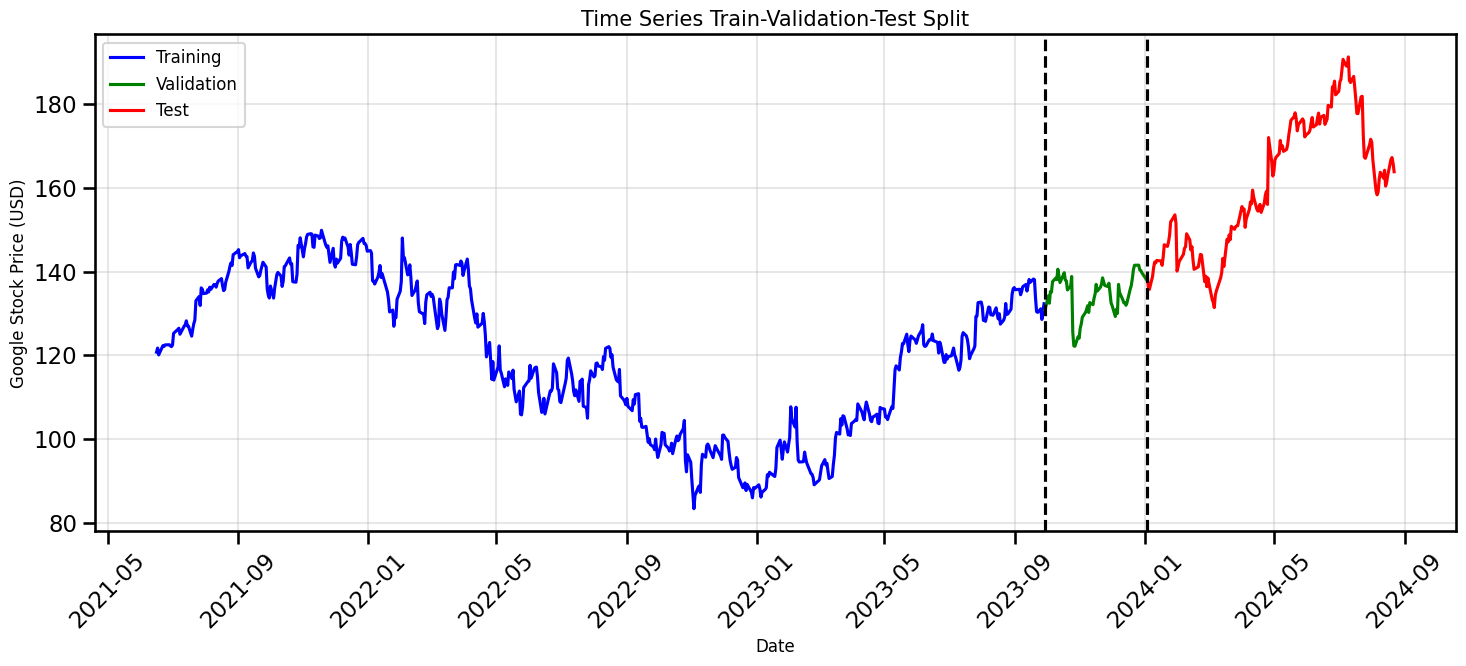

In [7]:
def plot_time_series_split(train_df, val_df, test_df, target_col='target'):
    plt.figure(figsize=(15, 7))
    
    # Plot each segment
    plt.plot(train_df['Date'], train_df[target_col], label='Training', color='blue')
    plt.plot(val_df['Date'], val_df[target_col], label='Validation', color='green')
    plt.plot(test_df['Date'], test_df[target_col], label='Test', color='red')
    
    # Add vertical lines at split points
    plt.axvline(x=val_df['Date'].min(), color='black', linestyle='--')
    plt.axvline(x=test_df['Date'].min(), color='black', linestyle='--')
    
    plt.title('Time Series Train-Validation-Test Split', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Google Stock Price (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot the split
plot_time_series_split(train_df, val_df, test_df)

## 5. Your First MLflow Run

Now let's create a simple MLflow run to log some basic information. This will help us understand how MLflow tracking works.

In [8]:
# Start an MLflow run
with mlflow.start_run(run_name="first_run") as run:
    # Log parameters
    mlflow.log_param("train_size", len(train_df))
    mlflow.log_param("val_size", len(val_df))
    mlflow.log_param("test_size", len(test_df))
    mlflow.log_param("train_start_date", train_df['Date'].min())
    mlflow.log_param("train_end_date", train_df['Date'].max())
    
    # Log tags
    mlflow.set_tag("data_version", "v1")
    mlflow.set_tag("description", "Initial exploration")
    
    # Log metrics (even simple statistics count as metrics)
    mlflow.log_metric("mean_price", train_df['target'].mean())
    mlflow.log_metric("median_price", train_df['target'].median())
    mlflow.log_metric("price_std", train_df['target'].std())
    
    # Create a simple plot to log as an artifact
    plt.figure(figsize=(10, 6))
    plt.plot(train_df['Date'], train_df['target'])
    plt.title('Google Stock Price Training Data')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig("outputs/train_price_plot.png")
    plt.close()
    
    # Log the saved figure as an artifact
    mlflow.log_artifact("outputs/train_price_plot.png")
    
    # Get run ID for reference
    run_id = run.info.run_id
    print(f"Completed run with ID: {run_id}")

Completed run with ID: 5e029d20b7ba4a9cbc9529ee5bc29250
🏃 View run first_run at: http://localhost:5000/#/experiments/791398403736460061/runs/5e029d20b7ba4a9cbc9529ee5bc29250
🧪 View experiment at: http://localhost:5000/#/experiments/791398403736460061


## 6. Using MLflow to Track a Simple Model Training

Let's train a basic XGBoost model and use MLflow to track its performance.

In [9]:
def prepare_features_target(df):
    """Prepare features and target for model training"""
    # Define feature columns (exclude Date and target)
    feature_cols = [col for col in df.columns if col not in ['Date', 'target']]
    
    # Extract features and target
    X = df[feature_cols].values
    y = df['target'].values
    
    return X, y, feature_cols

# Prepare data for modeling
X_train, y_train, features = prepare_features_target(train_df)
X_val, y_val, _ = prepare_features_target(val_df)
X_test, y_test, _ = prepare_features_target(test_df)

print(f"Training with {X_train.shape[1]} features and {X_train.shape[0]} samples")

Training with 303 features and 576 samples


In [10]:
# Define model parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'seed': 42,
    'early_stopping_rounds': 20,
}

# Start an MLflow run for model training
with mlflow.start_run(run_name="simple_xgboost_model") as run:
    # Log model parameters
    for param, value in params.items():
        mlflow.log_param(param, value)
    
    # Set relevant tags
    mlflow.set_tag("model_type", "xgboost")
    mlflow.set_tag("purpose", "baseline")
    
    # Train the model
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Log metrics
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("val_r2", val_r2)
    mlflow.log_metric("test_r2", test_r2)
    
    # Create and log a simple prediction plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['Date'], y_test, label='Actual', color='blue')
    plt.plot(test_df['Date'], y_test_pred, label='Predicted', color='red', alpha=0.7)
    plt.title('Test Set: Actual vs Predicted Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("outputs/test_predictions.png")
    plt.close()
    
    # Log the plot as an artifact
    mlflow.log_artifact("outputs/test_predictions.png", "plots")
    
    # Create model signature
    from mlflow.models.signature import infer_signature
    signature = infer_signature(X_train, y_train_pred)
    
    # Provide input example
    input_example = X_train[:4]
    
    # Log the model with signature and input example
    mlflow.xgboost.log_model(
        model, 
        "xgboost_model",
        signature=signature,
        input_example=input_example,
        model_format="json"
    )
    
    # Get run ID for reference
    run_id = run.info.run_id
    print(f"Model training completed. Run ID: {run_id}")
    print(f"\nModel Performance:")
    print(f"  Train RMSE: ${train_rmse:.2f}")
    print(f"  Validation RMSE: ${val_rmse:.2f}")
    print(f"  Test RMSE: ${test_rmse:.2f}")

Model training completed. Run ID: e622573fe1ab47499a65bd721e778871

Model Performance:
  Train RMSE: $1.29
  Validation RMSE: $3.00
  Test RMSE: $22.57
🏃 View run simple_xgboost_model at: http://localhost:5000/#/experiments/791398403736460061/runs/e622573fe1ab47499a65bd721e778871
🧪 View experiment at: http://localhost:5000/#/experiments/791398403736460061


## 7. Exploring Your MLflow Runs

Let's look at how to retrieve and examine our MLflow runs.

In [11]:
# Get information about all runs in our experiment
client = MlflowClient()

# Search for runs in our experiment
runs = client.search_runs(
    experiment_ids=[experiment_id],
    max_results=100
)

# Display run information
if runs:
    # Convert to dataframe for better display
    runs_data = []
    for run in runs:
        run_data = {
            "run_id": run.info.run_id,
            "run_name": run.data.tags.get("mlflow.runName", "[unnamed]"),
            "status": run.info.status,
            "start_time": datetime.fromtimestamp(run.info.start_time/1000).strftime('%Y-%m-%d %H:%M:%S'),
        }
        
        # Add metrics if they exist
        if "test_rmse" in run.data.metrics:
            run_data["test_rmse"] = run.data.metrics["test_rmse"]
        if "test_r2" in run.data.metrics:
            run_data["test_r2"] = run.data.metrics["test_r2"]
            
        runs_data.append(run_data)
    
    runs_df = pd.DataFrame(runs_data)
    display(runs_df)
else:
    print("No runs found in this experiment")

,run_id,run_name,status,start_time,test_rmse,test_r2
0,e622573fe1ab47499a65bd721e778871,simple_xgboost_model,FINISHED,2025-02-19 14:13:21,22.570971,-1.046365
1,5e029d20b7ba4a9cbc9529ee5bc29250,first_run,FINISHED,2025-02-19 14:13:21,NaN,NaN


## 8. Loading a Model from MLflow

One of the key benefits of MLflow is that it allows you to easily load saved models.

In [12]:
# Let's load our model from the latest run
if runs:
    # Get the run ID with the model
    latest_model_run_id = [run.info.run_id for run in runs 
                      if run.data.tags.get("mlflow.runName") == "simple_xgboost_model"][0]
    
    # Construct the model URI
    model_uri = f"runs:/{latest_model_run_id}/xgboost_model"
    
    # Load the model
    loaded_model = mlflow.xgboost.load_model(model_uri)
    print(f"Successfully loaded model from run: {latest_model_run_id}")
    
    # Make a sample prediction to verify it works
    sample_pred = loaded_model.predict(X_test[:3])
    print(f"\nSample predictions: {sample_pred}")
    print(f"Actual values: {y_test[:3]}")
else:
    print("No runs found with models to load")

Successfully loaded model from run: e622573fe1ab47499a65bd721e778871

Sample predictions: [136.70418 138.09763 133.13115]
Actual values: [138.9199982 136.3899994 135.7299957]


## 9. Organizing MLflow Experiments

As your project grows, you'll want to organize experiments by purpose. Let's create additional experiments for different aspects of our modeling process.

In [13]:
# Create experiments for different purposes
experiment_names = [
    "google_stock_feature_engineering",  # For tracking feature creation and selection
    "google_stock_model_optimization",   # For hyperparameter tuning
    "google_stock_model_registry"        # For production models
]

for name in experiment_names:
    if mlflow.get_experiment_by_name(name) is None:
        experiment_id = mlflow.create_experiment(
            name=name,
            artifact_location=os.path.join(mlflow_tracking_file, name.replace(" ", "_"))
        )
        print(f"Created new experiment: {name} with ID: {experiment_id}")
    else:
        experiment_id = mlflow.get_experiment_by_name(name).experiment_id
        print(f"Experiment already exists: {name} with ID: {experiment_id}")

Created new experiment: google_stock_feature_engineering with ID: 866255455360708975
Created new experiment: google_stock_model_optimization with ID: 411132893485505118
Created new experiment: google_stock_model_registry with ID: 481615501224794552


## 10. Best Practices for MLflow with Time Series

Here are some best practices specific to time series projects:

### 1. Log Time Windows

Always log the time ranges for your training, validation, and test sets. This is crucial for time series because performance can vary dramatically across different time periods.

In [14]:
# Example of logging time windows
with mlflow.start_run(run_name="time_window_example") as run:
    # Log time windows as parameters
    mlflow.log_param("train_start_date", train_df['Date'].min())
    mlflow.log_param("train_end_date", train_df['Date'].max())
    mlflow.log_param("val_start_date", val_df['Date'].min())
    mlflow.log_param("val_end_date", val_df['Date'].max())
    mlflow.log_param("test_start_date", test_df['Date'].min())
    mlflow.log_param("test_end_date", test_df['Date'].max())
    
    # Set a tag for evaluation type
    mlflow.set_tag("evaluation_type", "walk_forward")
    
    print(f"Logged time window information in run: {run.info.run_id}")

Logged time window information in run: 109110ed927f42fbaccc18b78faa4374
🏃 View run time_window_example at: http://localhost:5000/#/experiments/791398403736460061/runs/109110ed927f42fbaccc18b78faa4374
🧪 View experiment at: http://localhost:5000/#/experiments/791398403736460061


### 2. Track Feature Engineering Steps

Feature engineering is especially important for time series. Log your feature creation process.

In [15]:
# Example of tracking feature engineering
mlflow.set_experiment("google_stock_feature_engineering")

with mlflow.start_run(run_name="lag_features") as run:
    # Log feature parameters
    mlflow.log_param("max_lag", 365)
    mlflow.log_param("use_price_lags", True)
    mlflow.log_param("use_volume_lags", True)
    
    # Log metrics about features
    num_features = len([col for col in historical_data.columns 
                         if col not in ['Date', 'target']])
    mlflow.log_metric("num_features", num_features)
    
    # Set descriptive tags
    mlflow.set_tag("feature_type", "lag_based")
    mlflow.set_tag("feature_version", "v1")
    
    # Create and log a sample feature list
    lag_features = [col for col in historical_data.columns if '_lag_' in col]
    with open("outputs/lag_feature_list.txt", "w") as f:
        f.write("\n".join(lag_features[:10]))
    
    mlflow.log_artifact("outputs/lag_feature_list.txt")
    
    print(f"Logged feature engineering information in run: {run.info.run_id}")

Logged feature engineering information in run: 01659ce3c037444f82ba75a299608670
🏃 View run lag_features at: http://localhost:5000/#/experiments/866255455360708975/runs/01659ce3c037444f82ba75a299608670
🧪 View experiment at: http://localhost:5000/#/experiments/866255455360708975


### 3. Use Time Series Specific Metrics

Track metrics that matter for time series, like direction accuracy (how often we correctly predict up/down movement).

In [16]:
def calculate_direction_accuracy(y_true, y_pred):
    """Calculate how often we correctly predict price movement direction"""
    # Create arrays of price changes
    y_true_direction = np.diff(y_true) > 0  # True if price went up
    y_pred_direction = np.diff(y_pred) > 0  # True if we predicted price would go up
    
    # Calculate accuracy
    accuracy = np.mean(y_true_direction == y_pred_direction)
    return accuracy

# Return to our main experiment
mlflow.set_experiment("google_stock_prediction")

with mlflow.start_run(run_name="ts_specific_metrics") as run:
    # Use our previously loaded model to make predictions
    if 'loaded_model' in locals():
        # Make predictions
        y_train_pred = loaded_model.predict(X_train)
        y_val_pred = loaded_model.predict(X_val)
        y_test_pred = loaded_model.predict(X_test)
        
        # Calculate direction accuracy
        train_dir_acc = calculate_direction_accuracy(y_train, y_train_pred)
        val_dir_acc = calculate_direction_accuracy(y_val, y_val_pred)
        test_dir_acc = calculate_direction_accuracy(y_test, y_test_pred)
        
        # Log these metrics
        mlflow.log_metric("train_direction_accuracy", train_dir_acc)
        mlflow.log_metric("val_direction_accuracy", val_dir_acc)
        mlflow.log_metric("test_direction_accuracy", test_dir_acc)
        
        print(f"Test set direction accuracy: {test_dir_acc:.2%}")
        print(f"Logged time series specific metrics in run: {run.info.run_id}")
    else:
        print("No model available for metric calculation")

Test set direction accuracy: 49.38%
Logged time series specific metrics in run: 62d8857bd9544ba6899d94e47829bea2
🏃 View run ts_specific_metrics at: http://localhost:5000/#/experiments/791398403736460061/runs/62d8857bd9544ba6899d94e47829bea2
🧪 View experiment at: http://localhost:5000/#/experiments/791398403736460061


## 11. Summary and Next Steps

In this lesson, we've set up MLflow for our time series forecasting project and learned the basics of experiment tracking. Here's what we covered:

1. **MLflow Setup**: Configured MLflow to track experiments locally
2. **Data Preparation**: Split our data chronologically for time series modeling
3. **Basic Logging**: Created runs to track parameters, metrics, and artifacts
4. **Model Tracking**: Trained and logged a simple XGBoost model
5. **Model Loading**: Loaded a model from MLflow for inference
6. **Experiment Organization**: Created separate experiments for different project phases
7. **Time Series Best Practices**: Learned specific approaches for time series projects

### Next Steps

In the upcoming lessons, we'll build on this foundation:

- **Lesson 2: MLflow Feature Engineering** - Track and compare different feature sets
- **Lesson 3: Model Registry and Versioning** - Manage model lifecycle with MLflow
- **Lesson 4: Automated Backtesting** - Create backtesting pipelines with MLflow tracking
- **Lesson 5: Retraining with New Data** - Implement continuous retraining workflows

MLflow will help us maintain reproducibility and organization as our stock price prediction project grows in complexity.